# A novel Digital Beam-Forming Concept for spaceborne Reflector SAR Systems

Author : Rishikesh Kakade - rkakade@protonmail.com

This notebook aims to reproduce the results of this paper published in the Proceedings of the 6th European Radar Conference. 

[A novel Digital Beam-Forming Concept for spaceborne Reflector SAR Systems](https://ieeexplore.ieee.org/abstract/document/5306998)

Many methods are taken from this book by Bu-Chin Wang.

[Digital Signal Processing Techniques and Applications in Radar Signal Image Processing](https://www.wiley.com/en-us/Digital+Signal+Processing+Techniques+and+Applications+in+Radar+Image+Processing-p-9780470377826)

## Problem Formulation

At the time this paper was written, most Synthetic Aperture Radars (SAR) employed the use of planar phased antenna arrays, like the one in Figure 1.1, to direct the gain pattern of the antenna toward targets on the ground.

<figure>
  <img src="images/planar.jpg" width=200 height=200 />
  <figcaption>Figure 1.1 - Ballistic Missile Early Warning System in Alaska using a planar antenna array.</figcaption>
</figure> 

The downside with this design is that the swath area illuminated on the ground by two adjacent antenna elements overlaps significantly. To overcome this, the paper suggests the use of a parabolic reflector dish, that places the antenna array feed at the focus of the dish.  

<figure>
  <img src="images/parabolic.png" width=200 height=200 />
  <figcaption>Figure 1.2 - Parabolic reflector with offset antenna feed.</figcaption>
</figure> 

The result is a lighter system, requiring a smaller feed array with lower power demands, to produce an equivalently sized antenna aperture. The convenient radiation characteristics make it possible to direct EM energy in a very sharp beam, which minimizes losses at the swath borders. The new antenna architecture necessitates a custom beamforming algorithm be devised.  

## Proposed Solution

<figure>
  <img src="images/algorithmic_flow.png" width=200 height=200 />
  <figcaption>Figure 2.1 - Diagram of algorithmic flow.</figcaption>
</figure> 

The flow breaks down into two main stages: data synthesis then processing. 

In the synthesis stage, the goal is to generate the raw data that a SAR with a linear antenna array and parabolic reflector dish would recieve along all channels. First, a symmetric chirp signal is is generated to model the initial pulse the radar transmits to begin imaging the ground. Next, the signal is normalized for how it would really be transmitted on the ground given the structure of the radar and reflector. The gain pattern of this structure is not isotropic (meaning spherical) and so it is necesary to adjust the amplitude of the signal depending on how the signal is physically projected on the ground. Then, an artificial environment is constructed as a point scatterer in the middle of the ocean. In real radar images, water bodies appear black because water absorbs the signal and very little is reflected back. 

In the processing stage, the recieved signal is range compressed to select channels that are significant. Then a technique to create a cohesive image using a very high order filter called conjugate field matching is applied. 

## Data Sources

The mathematical description of SA radar operation was taken from Bu-Chin Wang's textbook, [Digital Signal Processing Techniques and Applications in Radar Signal Image Processing](https://www.wiley.com/en-us/Digital+Signal+Processing+Techniques+and+Applications+in+Radar+Image+Processing-p-9780470377826). Page numbers and equations are cited within the comments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
from collections import defaultdict
import scipy.io as scio
import sys

The basis for all SAR operation is the linear frequency modulated (LFM) pulse. A symmetric pulse from an isotropic radiator (a radiator whose 3 dB contour is the unit sphere) is modeled by, 
$$
p(t) = A_{0} Rect\left( \frac{1-0.5T_{p} }{T_{p}}\right)\exp[2 j \pi f_{c}(t-0.5T_{p})+j\pi\alpha (t-0.5T_{p})^{2}]
$$

Where, $A_{0}$ is the amplitude of the chirp, $T_{p}$ is the duration of the pulse, $T$ is the signal period, $f_{c}$ is the carrier frequency and $\alpha$ is the frequency ramp constant.

In [2]:
##########################################################
# These coefficients were taken from page 233 and 234 of Wang, 
# and modified with values from the paper where possible
##########################################################

#######################################################
# Linear chirp parameters
#######################################################
# Amplitude of Tx signal [m]
A_0 = 1.0
# Range FM rate/Frequency chirp rate [Hz/s]. f = f_c +alpha*t
alpha = 1e12
# Symmetric LFM pulse time duration [s]. This is the width of the rect func. 
T_p = 6.03333333333e-6
# Range sampling frequency [Hz]
f_s = 30e6
# Total period of pulse train [s]
T = T_p
# Radar beam carrier frequency [Hz]. C-Band from 4-8 Ghz
f_c = 5.4e9

In [3]:
def LFM_plot(p):
    fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
    a = axs.flat

    # plot chrip in time domain
    x = range(0, len(p))
    y1 = p.real
    y2 = p.imag

    a[0].plot(x, y1)
    a[0].set_title('LFM real part in time-domain')
    a[0].set_xlabel('Time sample')
    a[0].set_ylabel('Amplitude')

    a[1].plot(x, y2)
    a[1].set_title('LFM imaginary part in time-domain')
    a[1].set_xlabel('Time sample')
    a[1].set_ylabel('Amplitude')

    # plot spectrum
    sig = np.fft.fftshift(np.fft.fft(p))

    x = range(0, len(sig))
    y1 = abs(sig)
    y2 = np.angle(sig, deg=True)

    a[2].plot(x, y1)
    a[2].set_title('LFM spectrum magnitude response')
    a[2].set_xlabel('Frequency')
    a[2].set_ylabel('Magnitude')

    a[3].plot(x, y2)
    a[3].set_title('LFM wrapped phase response')
    a[3].set_xlabel('Frequency')
    a[3].set_ylabel('Angle')
        

In [4]:
def gen_symmetric_LFM(A_0, T_p, T, f_c, alpha, f_s):
    t = np.linspace(0, T, int(math.ceil(T*f_s)), endpoint=False) # time basis
    rect = np.where(abs((t-T_p/2)/T_p)<=0.5,1,0) # rect function to clip the 'infinite' function.
    p = A_0*rect*np.exp(1j*2*np.pi*f_c*(t-T_p/2) + 1j*np.pi*alpha*(t-T_p/2)**2) # symmetric LFM model, equation 5.11a from page 125 of Wang
    return p

In [5]:
p = gen_symmetric_LFM(A_0, T_p, T, f_c, alpha, f_s)

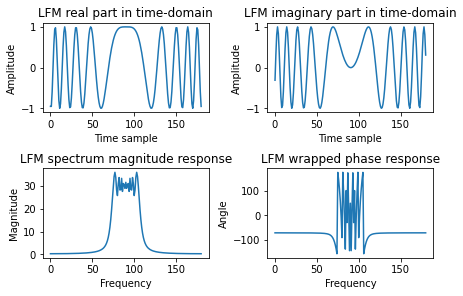

In [6]:
LFM_plot(p)

Figure 3.1

This chirp signal is first transmitted by the SAR. The target is imaged by processing the signal that echoes back from this pulse. A similar result is on page 128 of Wang.

This notebook will generate data as would be seen by a stripmap SAR.

<figure>
  <img src="images/stripmap.png" width=200 height=200 />
  <figcaption>Figure 3.2 - Schematic of stripmap SAR configuration.</figcaption>
</figure> 

Let's discuss some of the geometry,

<figure>
  <img src="images/geometry_strip.png" width=200 height=200 />
  <figcaption>Figure 3.3 - Geometry of stripmap imaging radar.</figcaption>
</figure> 

The radar moves with velocity $\bar{V}$ at height $H$, and has a swath range $R_{0}$ from the center of the swath. Each element in the LxW array illuminates a fraction of the footprint projected on the ground, each element illuminating an area that overlaps with the area illuminated by an adjacent element. For a rectangular array, the projected footprint is an ellipse with a major axis of length $R_{0}\frac{\lambda}{L}$ and a minor axis with length $R_{0}\frac{\lambda}{W}$. The swath is constructed by the union of all footprints created by successive radar pulses as the radar moves. The radar transmits pulses at a frequency called the pulse repetition frequency (PRF). The target being imaged lies along the swath median. The time interval for which the radar will illuminate the target is $R_{0}\frac{\lambda}{L}/|V|$. 

The paper suggests the radar antenna should be a linear phased array placed at the focus of a parabolic reflector dish. I used the antenna toolbox in Matlab to realize the system. Since the initial chirp was for an isotropic radiator, we have to normalize for our system architecture.

Wang derives the reasoning for this step on page 169. 

<figure>
  <img src="images/pattern.png" width=200 height=200 />
  <figcaption>Figure 3.4 - Simulation of gain pattern.</figcaption>
</figure> 

<figure>
  <img src="images/elevation.png" width=200 height=200 />
  <figcaption>Figure 3.5 - 3 dB elevation contour.</figcaption>
</figure> 

<figure>
  <img src="images/azimuth.png" width=200 height=200 />
  <figcaption>Figure 3.6 - 3 dB azimuth contour.</figcaption>
</figure> 

Text(0, 0.5, 'Amplitude')

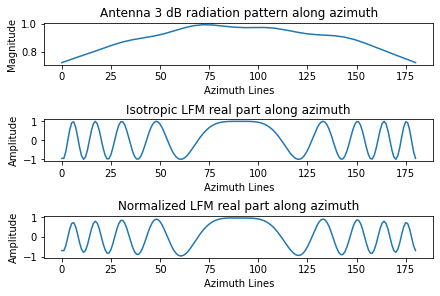

In [7]:

x_abs = scio.loadmat('radiation_pattern.mat')
x_abs = np.array(x_abs['x_abs']).flatten()
angles = np.linspace(0, 360, 361)
x_abs = (x_abs - np.min(x_abs)) / (np.max(x_abs) - np.min(x_abs))

rect = np.where(x_abs >= 1/math.sqrt(2), 1, 0).flatten() ## Extract part that is more than 3 dB
x_abs = x_abs*rect
angles = angles*rect

x_abs = x_abs[30:150]
angles = angles[30:150]

x_abs = x_abs[x_abs != 0.0]
angles = angles[angles!=0.0]

az_lines = np.linspace(angles[0], angles[-1], math.ceil(f_s*T_p))
gain = np.interp(az_lines, angles, x_abs) #make the gain array have the same number of points as the LFM pulse

fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True)

axs = axs.flat
axs[0].plot(np.linspace(0, 180, 181), gain)
axs[0].set_title('Antenna 3 dB radiation pattern along azimuth')
axs[0].set_xlabel('Azimuth Lines')
axs[0].set_ylabel('Magnitude')

x = range(0, len(p))
y1 = p.real

axs[1].plot(x, y1)
axs[1].set_title('Isotropic LFM real part along azimuth')
axs[1].set_xlabel('Azimuth Lines')
axs[1].set_ylabel('Amplitude')

y2 = p.real*gain
axs[2].plot(x, y2)
axs[2].set_title('Normalized LFM real part along azimuth')
axs[2].set_xlabel('Azimuth Lines')
axs[2].set_ylabel('Amplitude')
    

Figure 3.7

The difference is hard to notice but, look carefully near the signal edges. The high frequency components are surpressed. This normalized chirp signal is what will be projected on to the ground. 

This image recreates Figure 6.14 in Wang. 

In [8]:
p = p*gain # normalize the LFM chirp

Now model how this signal will echo back as the recieved signal. To develop a conceptual understanding, first consider the following target function of a single impulse. 
$$
f(x_{0}, y_{0}) = \sigma_{0}\delta(x-x_{0})
$$

It is some range away from the satellite on the ground, at coordinate ($x_{0}$, $y_{0}$, 0), and has a reflection coefficient $\sigma_{0}=1$ for simplicity. It's important to note that SAR imaging doesn't work like human vision; meaning the analog of the color spectrum is grayscale. The closest thing in real life that this models is a point reflector in the middle of the ocean as the surrounding water absorbs any radio signal directed toward it. 

In [9]:
##########################################################
# These coefficients were taken from page 233 and 234 of Wang
##########################################################

##########################################################
# Signal parameters
##########################################################
# Carrier phase velocity, light speed in vaccum/air [m/s]
v_ph = 299792458
# Carrier pulse repetition frequency [Hz]
f_PRF = 500
# Carrier wavelength [m]
lambda_c = v_ph/f_c
# Carrier frequency [Hz]
f_c = 5.4e9
# Range FM rate/Frequency chirp rate [Hz/s]. f = f_c +alpha*t
alpha = 4e12
# Sampling frequency [Hz]
f_s = 30e6

##########################################################
# Radar physical parameters
##########################################################
# Radar moving speed [m/s]
V = 200
# Antenna length [m]
L = 1

##########################################################
# Target parameters
##########################################################
# Position of target along flight path [m]
y_1 = 0 
# Range at closest approach to the target [m]
R_0 = 9000 # using the value of 7500 given for this in the book wouldn't work. I found this by trial and error... 

##########################################################
# Echo parameters
##########################################################
# Number of time samples within LFM pulse 
N_r = int(math.ceil(f_s*T_p))
# Number of time samples
N_tot = N_r

# Radar 3-dB azimuthal beamwidth (radians)
theta_H = lambda_c/L

# Azimuth sample spacing [m]
A_s = V/f_PRF
# Synthetic aperture length [m]
L_s = R_0*theta_H

# Number of azimuth samples 
N_az = math.ceil(L_s/A_s)

In [10]:
def baseband(f_c, tau_u_i, alpha, T_p, t_n): # equation 8.4c on page 229 of Wang
    return np.exp(-1j*2*np.pi*f_c*(tau_u_i)+ 1j*np.pi*alpha*(t_n-(T_p/2)-tau_u_i)**2)

In [11]:
def tau(u_i, y, R_0): # equation 8.5b on page 234 of Wang
    return 2 * math.sqrt((u_i-y)**2 + R_0**2)/v_ph 

In [12]:
def baseband_construction():
    # "Record" the Rx signal from the ground along N_az azimuth lines. 
    # The length of each signal is T samples long.
    r_b = np.zeros((N_az, N_tot)).astype(np.complex64)
    
    u_i = np.arange(0, N_az, A_s) # The radar recieves the signal at every u_i spaced out by A_s
    t_n = np.linspace(0, T, int(math.ceil(T*f_s)), endpoint=False) # time basis

    for i in range(N_az): # implement equation 8.4c on page 229 of Wang
        tau_u_i = tau(u_i[i], y_1, R_0) # equation 8.5b on page 234 of Wang
        rect = np.where(abs((t_n-T_p/2)/T_p)<=0.5,1,0) # rect function for making LFM pulse
        r_b[i] = baseband(f_c, tau_u_i, alpha, T_p, t_n)*abs(rect)**2 #*gain # compensate for the antenna gain pattern
        
    return r_b 

In [13]:
r_b = baseband_construction()

And with this, we have created our raw dataset! The image below is something like what a real radar would 'see' this enviroment as.  

(0.0, 1250.0)

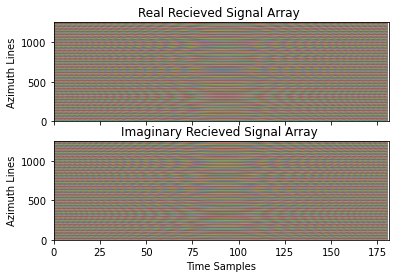

In [14]:
fig, axs = plt.subplots(2, sharex=True)
x = range(0, N_tot)
for i in range(1250):
    y_1 = r_b[i].real + i
    axs[0].plot(x, y_1*2)
    
    y_2 = r_b[i].imag + i
    axs[1].plot(x, y_2*2)
    
axs[0].set_title('Real Recieved Signal Array ')
axs[0].set_ylabel('Azimuth Lines')
axs[0].set_ylim([0,1250])
axs[0].set_xlim([0,N_tot])

axs[1].set_title('Imaginary Recieved Signal Array ')
axs[1].set_xlabel('Time Samples')
axs[1].set_ylabel('Azimuth Lines')
axs[1].set_ylim([0,1250])

Figure XXXX

Its a bit hard to interpret but tracing a line across the time axis shows oscillations in intensity, the red parts having low amplitude and blue parts having high amplitude. 

We can recreate Figure 4 from the paper (without the zero padding near edges) by simply plotting the time and frequency domains of one azimuth line. This is the signal that would be recieved by one of the channels on the antenna array. 

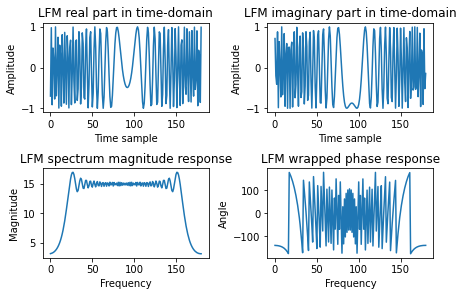

In [15]:
LFM_plot(r_b[0])

The magnitude response plot looks really interesting here! Notice three traits:
1. The center of the spectrum is higher in amplitude than the edge.
2. The center looks skewed to the left/is uneven. 
3. The overall spectrum 'stretched' over a wider range than in the case of the ideal, symmetric LFM pulse that was transmitted. 

The first two observations are explained by the antenna we designed that doesn't have an isotropic gain pattern. The edges of the azimuth line, which also contain the high frequency components of the signal are surpressed because of the gain pattern geomatry. Imprefections in my design of the antenna resulted in the unevenness. 

The third observation is intuitively explained by the doppler effect. Consider the basic case of a of a single frequency tone scattered by the ground being recieved by the radar as it moves toward then away from it (similar to an ambulance passing **close** by a pedestrian). As the radar approaches, it would observe a high  frequency tone that (roughly) linearly ramps up approach the true tone. As it retreats, it would observe the true tone linearly ramping down in frequency. The result is a wider magnitude response plot. This interesting feature is used to compensate and derive information about the true image on the ground.

The last thing to do is add a litte gaussian noise (AWGN) to each azimuth sample.

In [16]:
for i in range(N_az): # use a for loop because the noise on each channel should be uncorrelated
    noise = np.random.normal(0, 0.05, 181)
    r_b[i] = r_b[i] + noise

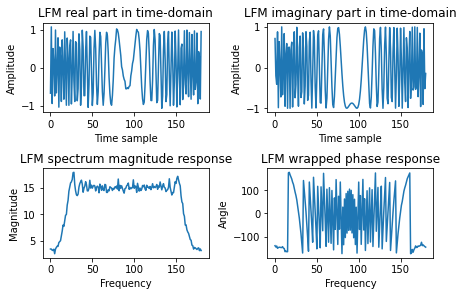

In [17]:
LFM_plot(r_b[0]) 

## Solution

The paper presents two novel methods for digital beamforming with this architecture along with two standard methods as a comparison with. 
* Method 1
    1. Range compression
    2. Determine channel weights using CFM 

In [18]:
def range_matched_filter(A_0, T_p, T, f_c, alpha, f_s):
    t = np.linspace(0, T, int(math.ceil(T*f_s)), endpoint=False) # time basis
    rect = np.where(abs((t-T_p/2)/T_p)<=0.5,1,0) # rect function to clip the 'infinite' function.
    p = A_0*rect*np.exp(1j*np.pi*alpha*(t-T_p/2)**2) # symmetric LFM model, equation 5.11a from page 125 of Wang
    return p

In [19]:
def range_compression(rb):
    rb_fq = np.fft.fftshift(np.fft.fft(rb))
    hr = range_matched_filter(A_0, T_p, T, f_c, alpha, f_s)
    hr_fq = np.fft.fftshift(np.fft.fft(hr))   
    res = rb_fq * hr_fq
    res = (np.fft.ifft(np.fft.fftshift(res)))  
    return res

In [20]:
r_b = range_compression(r_b)

In [21]:
def plot_range_compressed_pulses(p):
    # two subplots, the axes array is 1-d
    f, axarr = plt.subplots(2, sharex=True)
    (M, N) = p.shape
    x = range(0, N)
    for i in range(M):
        y1 = p[i].real*2 + i
        y2 = p[i].imag + i  
        # try commenting these two lines to get a nice visualization of all the pulses
        if i % 90 != 0:
           continue
   
        axarr[0].plot(x, y1)
        axarr[1].plot(x, y2)
        
    axarr[0].set_title('range compressed signal real part ')
    axarr[1].set_title('range compressed signal imaginary part ')

    axarr[1].set_xlabel('time samples')
    axarr[0].set_ylabel('azimuth samples')
    axarr[1].set_ylabel('azimuth samples')
    axarr[1].set_ylim([-10,M])
    axarr[0].set_ylim([-10,M])
    axarr[0].set_xlim([0,N])

In [22]:
def plot_magnitude_range_compressed_pulses(p):
    # two subplots, the axes array is 1-d
    
    (M, N) = p.shape
    x = range(0, N)
    for i in range(M):
        y1 = abs(p[i].real) + i
        
        # try commenting these two lines to get a nice visualization of all the pulses
        if i % 30 != 0:
           continue
   
        plt.plot(x, y1)

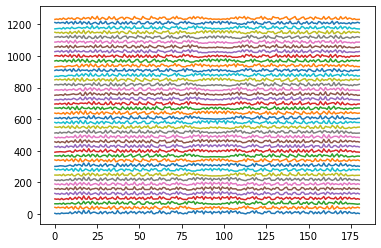

In [23]:
plot_magnitude_range_compressed_pulses(r_b)

In [24]:
def plot_fq_spectra_of_matched_filters():

    f, (ax1, ax2) = plt.subplots(2, 1)
    
    hr = range_matched_filter(A_0, T_p, T, f_c, alpha, f_s)
    ha = range_matched_filter(A_0, T_p, T, f_c, alpha, f_s)
        
    hr2 = np.fft.fftshift(np.fft.fft(hr))
    ha2 = np.fft.fftshift(np.fft.fft(ha)) 
        
    N = hr.shape[0]
    x1 = range(0, N)
    
    M = ha.shape[0]
    x2 = range(0, M)
    
    ax1.plot(abs(hr2))
    ax2.plot(abs(ha2))

    ax1.set_xlabel('frequency bins')
    ax1.set_ylabel('magnitude')
    ax2.set_xlabel('Doppler frequency bins')
    ax2.set_ylabel('magnitude')

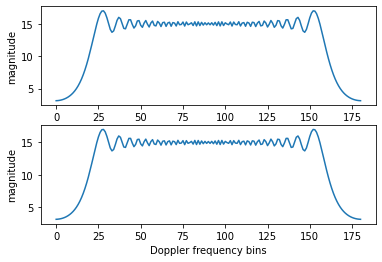

In [25]:
plot_fq_spectra_of_matched_filters()

## Visualization of Results

## Analysis and Conclusion

## References